## Explainability in Graph Neural Networks

Author: [Filippo Maria Bianchi](https://sites.google.com/view/filippombianchi/home).

Adapted from the original tutorial of [Simone Scardapane](https://www.sscardapane.it/).

Colab notebook [here](https://colab.research.google.com/drive/1nV44NrNqcXC2thU6-zzxnJPnIalo870m).

Libraries:

<img src="./imgs/libraries.png" width=700px />

In [88]:
import os, torch
os.environ['TORCH'] = torch.__version__
print("torch: ",torch.__version__)

# PyTorch imports
from torch.nn import functional as F

# PyTorch-related imports
import torch_geometric as pyg
import torch_scatter, torch_sparse
print("pyg: ",pyg.__version__)

# PyG explainability
from torch_geometric.explain import Explainer, GNNExplainer

import pytorch_lightning as ptlight
from torchmetrics.functional import accuracy

# Other imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
print("networkx: ",nx.__version__)

# Finally, Captum
import captum
from captum.attr import IntegratedGradients
from captum.influence import TracInCP, TracInCPFast
print("captum: ",captum.__version__)

torch:  1.13.0
pyg:  2.4.0
networkx:  2.8.4
captum:  0.6.0


## 1. Dataset exploration

We consider the [MUTAG](https://paperswithcode.com/dataset/mutag) dataset, a collection of nitroaromatic compounds. 
The goal is to predict their mutagenicity on Salmonella.

This is a toy version, so we do not care too much about the final performance. 

This part is re-adapted from the [PyG intro tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs).

Download the data

In [2]:
mutag = pyg.datasets.TUDataset(root='.', name='MUTAG')

Print some statistics about the dataset

In [3]:
print(f"graph samples: {len(mutag)}")
print(f"classes: {mutag.num_classes}") # Binary (graph-level) classification
print(f"node features: {mutag.num_features}") # One-hot encoding for each node type (atom)
print(f"edge features: {mutag.num_edge_features}") # One-hot encoding for the bond type (we will ignore this)

graph samples: 188
classes: 2
node features: 7
edge features: 4


Each graph in the dataset is represented as an instance of the generic [Data object](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)

In [4]:
mutag_0 = mutag[0]
print(type(mutag_0))

<class 'torch_geometric.data.data.Data'>


In [5]:
# x contains the node features
mutag_0.x.shape

torch.Size([17, 7])

In [6]:
# y contains the corresponding class
mutag_0.y

tensor([1])

The Edges are stored in a COO format, with a 2xE list (``edge_index[:, i]`` are the source and target nodes of the $i$-th edge)

In [7]:
mutag_0.edge_index.shape

torch.Size([2, 38])

In [8]:
# We print the first four edges in the list
mutag_0.edge_index[:, 0:4]

tensor([[0, 0, 1, 1],
        [1, 5, 0, 2]])

Inside ``pyg.utils`` there are a number of useful tools.

E.g., we can check that the graph is undirected (the adjacency matrix is symmetric))

In [9]:
pyg.utils.is_undirected(mutag_0.edge_index)

True

We define a simple function for plotting the graph using the tools from networkx

In [10]:
colors = list(mcolors.TABLEAU_COLORS)
def draw_graph(g: pyg.data.Data, ax=None):
  # Get a different color for each atom type
  node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]
  # Convert to networkx
  g = pyg.utils.to_networkx(g, to_undirected=True)
  # Draw on screen
  pos = nx.planar_layout(g)
  pos = nx.spring_layout(g, pos=pos)
  nx.draw_networkx(g, node_color=node_color, with_labels=False,
                   node_size=150, ax=ax)

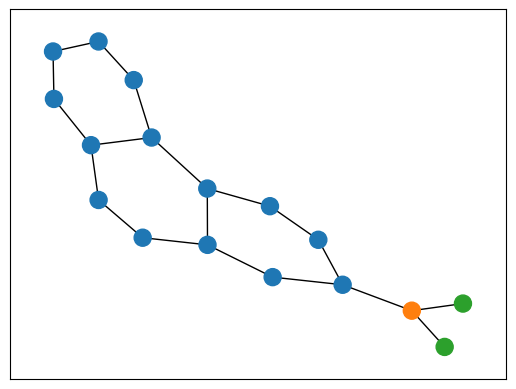

In [11]:
draw_graph(mutag_0)

In [12]:
from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_mask=None, draw_edge_labels=False, ax=None):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw_networkx(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', ax=ax)

    if ax is None:
      plt.show()


def to_molecule(data: pyg.data.Data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

We can also use a more advanced drawing script (taken from [here](https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing)) that also shows the atom type

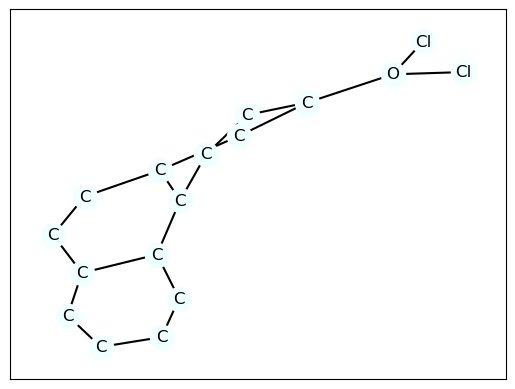

In [13]:
draw_molecule(to_molecule(mutag_0))

## 2. Transformations
Transformations are a quick way to include standard preprocessing when loading the graphs (e.g., automatically computing edge from the nodes positions). 

See the full list of available transformations [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html).

As an experiment, we load the graph with a sparse adjacency format instead of the COO list

In [14]:
mutag_adj = pyg.datasets.TUDataset(root='.', name='MUTAG',
                                   transform=pyg.transforms.ToSparseTensor())

We now have the adjacency matrix available as an additional propertyty)

In [15]:
mutag_adj[0].adj_t # This gives us useful information (size, nnz, density)

SparseTensor(row=tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
                            8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
                           15, 16]),
             col=tensor([ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
                            7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
                           14, 14]),
             size=(17, 17), nnz=38, density=13.15%)

The sparse matrix format supports [several useful methods](https://github.com/rusty1s/pytorch_sparse).

For example, we can propagate the features on the graph (cornerstone of graph-based methods) efficiently with a sparse-dense matrix multiplication

In [16]:
print(torch_sparse.matmul(mutag_adj[0].adj_t, mutag_adj[0].x).shape)

torch.Size([17, 7])


## 3. Data loaders

Data loaders are a nice utility to automatically build mini-batches from the dataset.

A batch can either be a set of graphs, or subgraphs extracted from a single graph.

First, we split the original dataset into a training and a test part with a stratified split on the class

In [17]:
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25)

Then, we build the two loaders

In [18]:
train_loader = pyg.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = pyg.loader.DataLoader(mutag[test_idx], batch_size=32)

Let us load the first batch of data

In [19]:
batch = next(iter(train_loader))

The batch is built by considering all the subgraphs as a single giant graph with unconnected components

<img src="imgs/disjoint.PNG" width=400px />

In [20]:
print(f"x shape: {batch.x.shape}") # All the nodes of the 32 graphs are put together
print(f"y shape: {batch.y.shape}") # A single label for each graph
print(f"edges shape: {batch.edge_index.shape}") # Edge list of all 32 graphs

x shape: torch.Size([566, 7])
y shape: torch.Size([32])
edges shape: torch.Size([2, 1242])


There is an additional property in ``batch`` that links each node to its corresponding graph index

In [21]:
print(batch.batch.shape)
print(batch.batch[0:30]) # print the first 30 elements

torch.Size([566])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


We can perform graph-level operations with ``torch_scatter`` (more details [here](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html))

<img src="imgs/scatter.PNG" width=400px />

In [22]:
# Sum all the nodes in the same graph
print(torch_scatter.scatter_sum(batch.x, batch.batch, dim=0).shape)

torch.Size([32, 7])


In [23]:
# Average all the nodes in the same graph
print(torch_scatter.scatter_mean(batch.x, batch.batch, dim=0).shape)

torch.Size([32, 7])


In [24]:
# Alternatively, PyG has this implemented as a functional layer
pyg.nn.global_mean_pool(batch.x, batch.batch).shape

torch.Size([32, 7])

## 4. Building the GNN

Layers in PyG are very similar to standard PyTorch layers.

This is a standard graph convolutional layer.

In [25]:
gcn = pyg.nn.GCNConv(7, 12)

In [26]:
gcn(batch.x, batch.edge_index).shape

torch.Size([566, 12])

Different layers have different properties 

See [this cheatsheet](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html) from more info.

For example, GCNConv accepts an additional ``edge_weight`` parameter to weight each edge. 

We will use this later on, to mask the corresponding edges for the prediction.

### 4.1 Pytorch lightning

PyTorch Lightning is a lightweight wrapper around the PyTorch framework that helps organize PyTorch code, making it more readable and maintainable.

It simplifies the complex engineering tasks involved in PyTorch models removing a lot of boilerplate code.

If you are not famliar with PyTorch Lightning, see this [5-minutes intro](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

#### 4.1.1 The Lightning Module

<img src="imgs/pl_module.png" width=800px />

In [27]:
class MUTAGClassifier(ptlight.LightningModule):

    def __init__(self):
      # The model is just GCNConv --> GCNConv --> global pooling --> Dropout --> Linear
      super().__init__()
      self.gc1 = pyg.nn.GCNConv(7, 64)
      self.gc2 = pyg.nn.GCNConv(64, 256)
      self.linear = torch.nn.Linear(256, 1)

    def forward(self, x, edge_index=None, batch=None, edge_weight=None):
      # Note: "edge_weight" is not used for training, but only for the explainability part
      if edge_index == None:
        x, edge_index, batch = x.x, x.edge_index, x.batch
      x = F.relu(self.gc1(x, edge_index, edge_weight))
      x = F.relu(self.gc2(x, edge_index, edge_weight))
      x = pyg.nn.global_mean_pool(x, batch)
      x = F.dropout(x)
      x = self.linear(x)
      return x

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

    def training_step(self, batch, _):
      y_hat = self.forward(batch.x, batch.edge_index, batch.batch)
      loss = F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float())
      self.log("train_loss", loss)
      self.log("train_accuracy", accuracy(y_hat, batch.y.unsqueeze(1), task='binary'), prog_bar=True, batch_size=32)
      return loss

    def validation_step(self, batch, _):
        x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
        y_hat = self.forward(x, edge_index, batch_idx)
        self.log("val_accuracy", accuracy(y_hat, batch.y.unsqueeze(1), task='binary'), prog_bar=True, batch_size=32)

We instantiate the classifier

In [28]:
gnn = MUTAGClassifier() # PL module

Sanity check: we run a single mini-batch and check the output shape

In [29]:
gnn(batch.x, batch.edge_index, batch.batch).shape

torch.Size([32, 1])

#### 4.1.2 The training loop

<img src="imgs/pl_train.png" width=800px />

Save weights of the model during training

In [30]:
checkpoint_callback = ptlight.callbacks.ModelCheckpoint(
    dirpath='./checkpoints/',
    filename='gnn-{epoch:02d}',
    every_n_epochs=50,
    save_top_k=-1)

Create the trainer

In [31]:
trainer = ptlight.Trainer(max_epochs=150, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/filippo/anaconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Start the training loop

In [32]:
# This is not a particularly well-designed model, we expect approximately 70-80% val accuracy
trainer.fit(gnn, train_loader, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type    | Params
-----------------------------------
0 | gc1    | GCNConv | 512   
1 | gc2    | GCNConv | 16.6 K
2 | linear | Linear  | 257   
-----------------------------------
17.4 K    Trainable params
0         Non-trainable params
17.4 K    Total params
0.070     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/filippo/anaconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/filippo/anaconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/filippo/anaconda3/envs/pyg/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=150` reached.


## 5. Explainability

### 5.1 GNNExplainer

[GNNExplainer](https://arxiv.org/abs/1903.03894) is a simple method to search for instance-level explanations on a trained GNN. 

It optimizes for the smallest feature and edge masks that do not vary the prediction of the trained model.  

<img src="imgs/GNNexplainer.PNG" width=800px />

We take a single graph from the test dataset

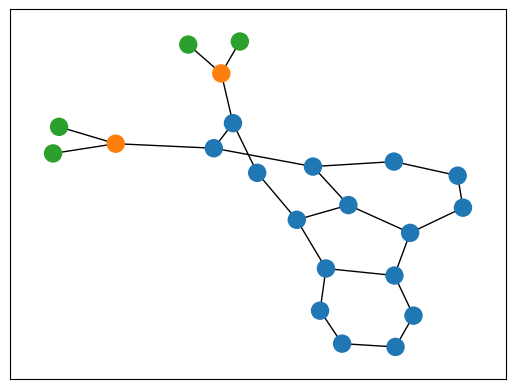

In [33]:
idx = 0
test_graph = mutag[test_idx[idx]]

draw_graph(test_graph)

In [34]:
# Explanations are mostly interesting for mutagenic graphs
print(test_graph.y)

tensor([1])


PyG has an implementation of GNNExplainer that we will use.

It provides a mask that can remove individual features for each node.

In [35]:
# Instantiate the explainer
explainer = Explainer(
        model=gnn,
        algorithm=GNNExplainer(epochs=300),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw',
        ),
    )

In [36]:
# Compute the explanations
explanation = explainer(test_graph.x, test_graph.edge_index)

These are the resulting masks.

In [37]:
print(explanation)

Explanation(node_mask=[22, 7], edge_mask=[50], prediction=[1, 1], target=[1], x=[22, 7], edge_index=[2, 50])


We mostly care about the edges here.

In [38]:
explanation.edge_mask

tensor([0.0322, 0.0369, 0.0410, 0.0401, 0.0363, 0.0415, 0.0340, 0.0341, 0.0368,
        0.0443, 0.0419, 0.0393, 0.0369, 0.0333, 0.0417, 0.0404, 0.0408, 0.0363,
        0.0389, 0.0335, 0.0252, 0.0400, 0.0465, 0.0368, 0.0397, 0.0549, 0.0455,
        0.0473, 0.0420, 0.0431, 0.0352, 0.0485, 0.0410, 0.0450, 0.0552, 0.0453,
        0.0584, 0.0482, 0.0626, 0.0737, 0.0592, 0.0607, 0.9391, 0.9240, 0.9459,
        0.0922, 0.0538, 0.0559, 0.9325, 0.9292])

Get the relevant edges (highest values inside the edge mask)

In [43]:
relevant_edges = explanation.edge_mask > 0.90

We build the subgraph corresponding to the explanation

In [44]:
explanation_subgraph = pyg.data.Data(test_graph.x, test_graph.edge_index[:, relevant_edges])

In [45]:
# Make undirected and remove the isolated nodes
explanation_subgraph = pyg.transforms.RemoveIsolatedNodes()(pyg.transforms.ToUndirected()(explanation_subgraph))

A good explanation should contain $CI_2O$ groups, which are known to be mutagenic

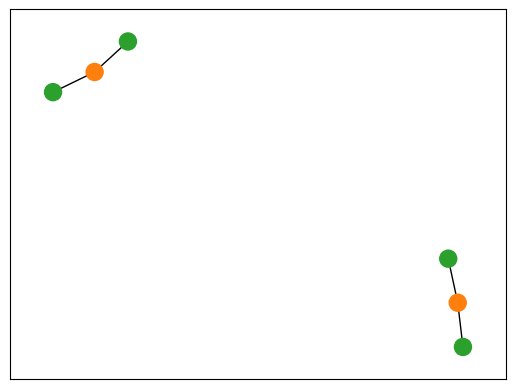

In [46]:
draw_graph(explanation_subgraph)

We can also use the other visualizer

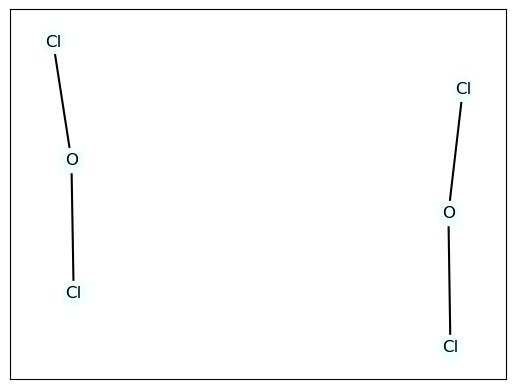

In [47]:
draw_molecule(to_molecule(explanation_subgraph))

### 5.2 Integrated Gradients

Instead of using a custom-made explainer, we can also try using a "standard" one. 

For example, here we use the implementation of **Integrated Gradients** provided by Captum. 

#### How IG works?

1. **Baseline Selection:** Choose a baseline representing a non-informative input (e.g., a black image).

2. **Path Construction:** Construct a path from this baseline to the actual input, that gradually changes the baseline into the actual input.

<img src="imgs/IG_path.PNG" width=800px />

3. **Gradient Calculation:** At each step along this path, the gradient of the model output with respect to the input is calculated.

    This gradient signifies how much each input feature contributes to the output.

4. **Integration:** The gradients across all the steps are summed up to quantify the importance of each input feature in determining the model's output.


<img src="imgs/IG_fireboat.png" width=600px />

In our case, we will integrate a "saliency vector" moving from a graph with no connectivity to our actual graph.

We define a custom function whose input is the edge mask.

In [48]:
batch_idx = torch.zeros(test_graph.x.shape[0], dtype=torch.int64) # All nodes belong to the same graph
gnn.eval() # disable dropout, turn off gradients computation
def model_forward(edge_mask, graph):
    out = gnn(graph.x, graph.edge_index, batch_idx, edge_weight=edge_mask[0])
    return out

We initialize the edge mask with all 1s

In [49]:
edge_mask = torch.ones(test_graph.edge_index.shape[1]).unsqueeze(0).requires_grad_(True)
print(edge_mask.shape)

torch.Size([1, 50])


In [50]:
model_forward(edge_mask, test_graph)

tensor([[1.6257]], grad_fn=<AddmmBackward0>)

We compute IG using the Captum [IntegratedGradients](https://captum.ai/docs/extension/integrated_gradients) class.

In [51]:
# Instantiate IG with the custom function we just defined
ig = IntegratedGradients(model_forward)

In [52]:
# Compute the mask
ig_mask = ig.attribute(edge_mask, additional_forward_args=test_graph, internal_batch_size=1)

This is the same as before, we just use the new mask

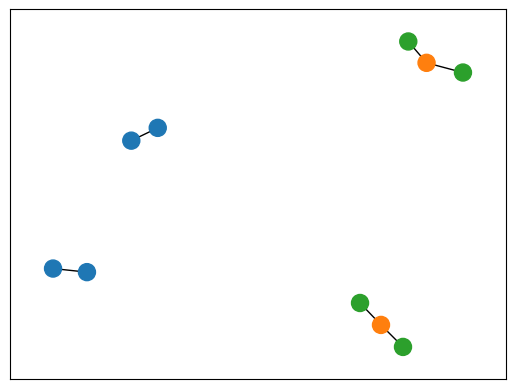

In [53]:
explanation = pyg.data.Data(test_graph.x, test_graph.edge_index[:, ig_mask[0] > 0.1])
explanation = pyg.transforms.RemoveIsolatedNodes()(pyg.transforms.ToUndirected()(explanation))
draw_graph(explanation)

### 5.3 TracIn

TracIn (Traceable Inputs) measures the impact of each training example on a specific prediction (e.g., the class of ``test_graph``). 

It helps to identify which training data points are most influential for a particular prediction.

TracIn computes the gradients of the loss for a particular data point (e.g., ``test_graph``) and for all training samples. 

By comparing these gradients, TracIn estimates the cumulative influence of each training example on the classification of the particular data point.

First, we manually select (some of) the checkpoints.

<img src="imgs/traceIN_1.png" width=600px />

In [68]:
!ls checkpoints

'gnn-epoch=149.ckpt'  'gnn-epoch=49.ckpt'  'gnn-epoch=99.ckpt'


In [69]:
ckpt = ['checkpoints/gnn-epoch=49.ckpt',
        'checkpoints/gnn-epoch=99.ckpt',
        'checkpoints/gnn-epoch=149.ckpt'
       ]

We will compute the gradient only with respect to the last linear layer of the GNN.

Remember that our GNN model is GCNConv $\rightarrow$ GCNConv $\rightarrow$ global pooling $\rightarrow$ Dropout $\rightarrow$ Linear

<img src="imgs/traceIN_2.png" width=300px />

In [70]:
params = gnn.linear.weight.shape[1]
print(params)

256


We will store here the gradients for the test graph on all checkpoints

In [71]:
test_gradients = torch.zeros((len(ckpt), params))

In [72]:
for k in range(len(ckpt)):

    # Manually load the checkpoint
    checkpoint = torch.load(ckpt[k])
    gnn.load_state_dict(checkpoint['state_dict'])
    gnn.eval()

    # Compute the gradient on the test graph
    y = gnn(test_graph.x, test_graph.edge_index)
    test_gradients[k] = torch.autograd.grad(y, gnn.linear.weight)[0]

We do the same also for all training points

In [73]:
mutag_train = mutag[train_idx] # Training set
train_gradients = torch.zeros((len(mutag_train), len(ckpt), params))

In [74]:
for k in range(len(ckpt)):

    # Manually load the checkpoint
    checkpoint = torch.load(ckpt[k])
    gnn.load_state_dict(checkpoint['state_dict'])
    gnn.eval()

    # Same as before, but we loop over all training graphs
    for i in range(len(mutag_train)):

      y = gnn(mutag_train[i].x, mutag_train[i].edge_index)
      train_gradients[i, k] = torch.autograd.grad(y, gnn.linear.weight)[0]

<img src="imgs/traceIN_3.png" width=700px />

In [75]:
# test_gradients.shape  = (   3, 256)
# train_gradients.shape = (141, 3, 256)
# This computes the relevance score for all graphs
relevance = (test_gradients * train_gradients).sum(dim=[1, 2])

In [76]:
relevance.shape

torch.Size([141])

In [77]:
# Take the top-k highest values (proponents), and top-k lowest values (opponents)
_, proponents = torch.topk(relevance, k=3, largest=True)
_, opponents = torch.topk(relevance, k=3, largest=False)

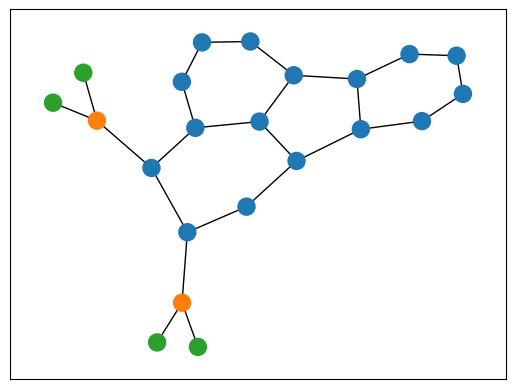

In [81]:
# Let's draw once again the test_graph
draw_graph(test_graph)

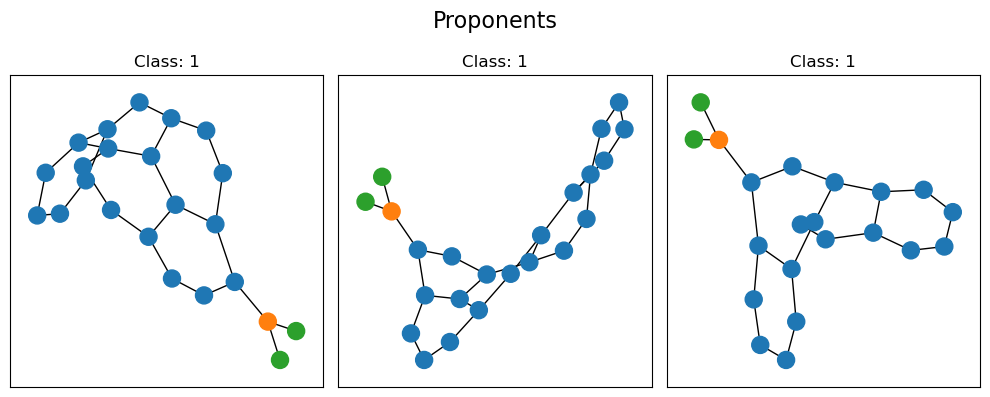

In [83]:
fig, axs = plt.subplots(1, 3, layout='tight', figsize=(10, 4))
for c, i in enumerate(proponents):
    draw_graph(mutag_train[i], ax=axs[c])
    sign_i = gnn(mutag_train[i].x, mutag_train[i].edge_index).sign()
    axs[c].set_title(f"Class: {mutag_train[i].y.numpy()[0]}")
fig.suptitle('Proponents', fontsize=16)
plt.show()

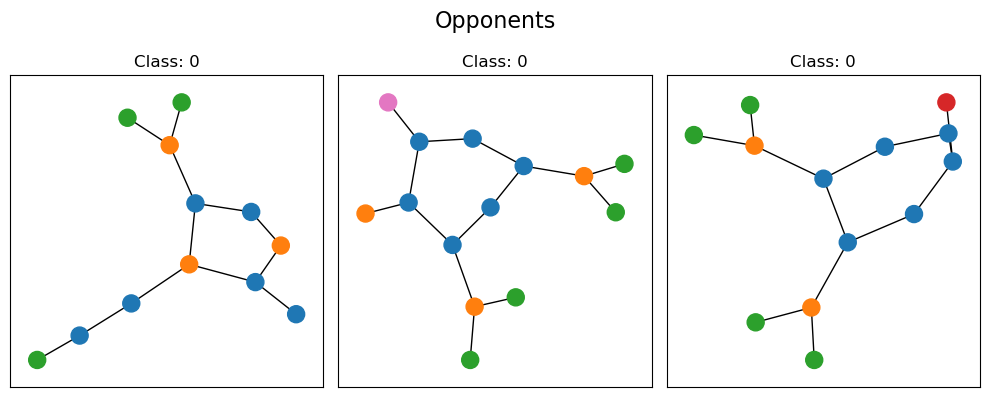

In [84]:
fig, axs = plt.subplots(1, 3, layout='tight', figsize=(10, 4))
for c, i in enumerate(opponents):
    draw_graph(mutag_train[i], ax=axs[c])
    sign_i = gnn(mutag_train[i].x, mutag_train[i].edge_index).sign()
    axs[c].set_title(f"Class: {mutag_train[i].y.numpy()[0]}")
fig.suptitle('Opponents', fontsize=16)
plt.show()

## The end

- Questions?
- Contact: filippo.m.bianchi@uit.no